# Imports and Data Loading

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

import shap

In [4]:
df = pd.read_csv('voterhistorywrangled.csv')

df.head()

,Unnamed: 0,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,district
0,0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,M,11700154.0,NORTH PLAINFIELD,1.0
1,2,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,M,11700160.0,NORTH PLAINFIELD,8.0
2,7,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,M,11700157.0,NORTH PLAINFIELD,4.0
3,8,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,M,11700151.0,NORTH PLAINFIELD,2.0
4,13,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,M,11700158.0,NORTH PLAINFIELD,5.0


In [5]:
df = df.drop(columns=['Unnamed: 0','ballot'])

df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,11700154.0,NORTH PLAINFIELD,1.0
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,11700157.0,NORTH PLAINFIELD,4.0
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,11700151.0,NORTH PLAINFIELD,2.0
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,11700158.0,NORTH PLAINFIELD,5.0


# Feature Engineering

In [63]:
#big feature engineering cell

#bools for male and female markers
df['male'] = (df['sex'] == 'M')
df['female'] = (df['sex'] == 'F')

#convert dates to datetimes for easier handling
df['birthdate'] = df['birthdate'].apply(pd.to_datetime)
df['registered'] = df['registered'].apply(pd.to_datetime)

#age at time of target election
df['age_2017'] = (pd.to_datetime('11/07/2017') 
                  - df['birthdate']).apply(lambda d: d.days /365)

#age at time of most recent voter registration
df['reg_age'] = (df['registered'] 
                  - df['birthdate']).apply(lambda d: d.days /365)
#if registration supposedly occurred at an implausible age, replace with nan
df['mask'] = df['reg_age'] > 1
df['reg_age'] = df['reg_age'].where(df['mask'],other=np.nan)
df = df.drop(columns='mask')

#how long since registration ("prior" to target election)
#suddenly, the centerpiece of the model
df['since_reg'] = (pd.to_datetime('11/07/2017') 
                  - df['registered']).apply(lambda d: d.days /365)

#bools for party affiliation
#all are wildly unimportant!
df['dem'] = (df['party_code'] == 'DEM')
df['rep'] = (df['party_code'] == 'REP')
df['una'] = (df['party_code'] == 'UNA') #I believe "unaffiliated"
df['3rd'] = ~(df['dem'] | df['rep'] | df['una'])

#feature idea: municipality
#ordinal encoded from lowest to highest target voting rate
muni_map = {'NORTH PLAINFIELD': 1,
            'MANVILLE BOROUGH': 2,
            'GREEN BROOK': 3,
            1: 1,
            2: 2,
            3: 3}#last part protects against loss of data when cell is re-run
df['municipality'] = df['municipality'].map(muni_map)

#naive voter score
#unfair to young voters who would have been unable to vote in earlier elections
#voting rate of previous four elections
df['voter_score'] = (df['06/02/2015'] + df['06/07/2016'] + df['11/08/2016'] + df['06/06/2017']) / 4



df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,...,male,female,age_2017,voter_score,since_reg,reg_age,dem,rep,una,3rd
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,...,False,True,52.517808,0.50,9.071233,43.446575,True,False,False,False
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,...,False,True,85.526027,1.00,1.978082,83.547945,True,False,False,False
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,...,False,False,87.252055,0.25,9.758904,77.493151,False,True,False,False
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,...,False,True,73.619178,1.00,8.830137,64.789041,True,False,False,False
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,...,False,False,71.120548,0.75,8.057534,63.063014,True,False,False,False


# Data Exploration

In [48]:
df[df['3rd']]

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,...,male,female,age_2017,voter_score,since_reg,reg_age,dem,rep,una,3rd
217,101552012,0.0,0.0,0.0,0.0,1.0,A,GRE,LITTLE,GREGORY,...,False,False,51.904110,1.0,15.065753,36.838356,False,False,False,True
377,104455443,0.0,0.0,0.0,0.0,1.0,A,GRE,BROXMEYER,DEBORAH,...,False,True,42.210959,1.0,0.424658,41.786301,False,False,False,True
465,104562959,0.0,0.0,1.0,1.0,1.0,A,LIB,HUSSEY-POLAND,PAMELA,...,False,True,49.339726,2.0,0.000000,49.339726,False,False,False,True
952,106188388,0.0,0.0,0.0,0.0,1.0,A,CON,LEWIS,LISA,...,False,True,40.482192,1.0,1.147945,39.334247,False,False,False,True
1156,106362180,0.0,0.0,0.0,1.0,1.0,A,GRE,ZEMPEL,CAROLE,...,False,True,41.076712,1.0,10.542466,30.534247,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21227,152554693,0.0,0.0,0.0,0.0,0.0,A,LIB,SANTANA,ALEC,...,False,True,22.898630,0.0,4.816438,18.082192,False,False,False,True
21313,535735229,0.0,0.0,0.0,0.0,0.0,A,GRE,BRANKER,TIFFANY,...,False,False,35.416438,0.0,0.871233,34.545205,False,False,False,True
21384,530801407,0.0,0.0,0.0,0.0,0.0,A,GRE,HERNANDEZ,KYLE,...,True,False,20.665753,0.0,1.221918,19.443836,False,False,False,True
21418,106193827,0.0,0.0,0.0,0.0,0.0,A,GRE,LOVE,BREON,...,False,False,37.934247,0.0,1.219178,36.715068,False,False,False,True


In [29]:
df['since_reg'].describe()
#some negative values...

count    21690.000000
mean        12.808437
std         12.991914
min         -0.424658
25%          3.134247
50%          9.101370
75%         17.142466
max         76.060274
Name: since_reg, dtype: float64

In [34]:
df['party_code'].value_counts(dropna=False)

UNA    9002
DEM    8025
REP    4486
LIB      48
CON      42
GRE      31
CNV      22
NAT      18
SSP      14
RFP       2
Name: party_code, dtype: int64

In [11]:
df['municipality'].value_counts(dropna=False)

NORTH PLAINFIELD    10947
MANVILLE BOROUGH     5690
GREEN BROOK          5053
Name: municipality, dtype: int64

In [15]:
print(df[df['municipality'] == "NORTH PLAINFIELD"]['11/07/2017'].mean())
print(df[df['municipality'] == "MANVILLE BOROUGH"]['11/07/2017'].mean())
print(df[df['municipality'] == "GREEN BROOK"]['11/07/2017'].mean())

0.34036722389695806
0.3771528998242531
0.39659608153572135


# Modeling

In [64]:
#split train and test, make target vectors and feature matrices

train, test = train_test_split(df)

target = '11/07/2017'
features = ['11/08/2016','06/06/2017','06/07/2016','06/02/2015','male','female',
            'age_2017','voter_score','since_reg','reg_age','dem','rep','una','3rd',
           'municipality']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [69]:
#fit model, evaluate accuracy
model = XGBClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

eval_set = [(X_train, y_train),(X_test, y_test)]

#optimize model
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

class_index = 1
y_pred_proba = model.predict_proba(X_test)[:, class_index]
print('Test Accuracy', model.score(X_test, y_test))
print('Test ROC AUC', roc_auc_score(y_test, y_pred_proba))
#well of course I prefer the one that gives me a higher number!

[0]	validation_0-auc:0.847055	validation_1-auc:0.837596
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.85293	validation_1-auc:0.844874
[2]	validation_0-auc:0.853061	validation_1-auc:0.844769
[3]	validation_0-auc:0.855122	validation_1-auc:0.847482
[4]	validation_0-auc:0.855557	validation_1-auc:0.848547
[5]	validation_0-auc:0.856542	validation_1-auc:0.849245
[6]	validation_0-auc:0.85679	validation_1-auc:0.850601
[7]	validation_0-auc:0.856914	validation_1-auc:0.850014
[8]	validation_0-auc:0.856828	validation_1-auc:0.849787
[9]	validation_0-auc:0.858136	validation_1-auc:0.851197
[10]	validation_0-auc:0.858412	validation_1-auc:0.851242
[11]	validation_0-auc:0.858615	validation_1-auc:0.851589
[12]	validation_0-auc:0.858783	validation_1-auc:0.851517
[13]	validation_0-auc:0.861284	validation_1-auc:0.854133
[14]	validation_0-auc:0.861326	validation_1-auc:0.854153


In [70]:
#feature importances
permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=5, 
    random_state=42
)

X_test_perm = X_test.fillna(0) #bad hack for permuter hating nans

permuter.fit(X_test_perm, y_test)

feature_names = X_test_perm.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)
#voter score comes out as most important by far!!

Weight,Feature
0.1801 ± 0.0176,voter_score
0.0352 ± 0.0088,since_reg
0.0151 ± 0.0019,06/06/2017
0.0093 ± 0.0045,11/08/2016
0.0063 ± 0.0023,age_2017
0.0014 ± 0.0005,municipality
0.0010 ± 0.0007,rep
0.0007 ± 0.0006,una
0.0006 ± 0.0006,female
0.0003 ± 0.0004,reg_age


# Data Visualizations

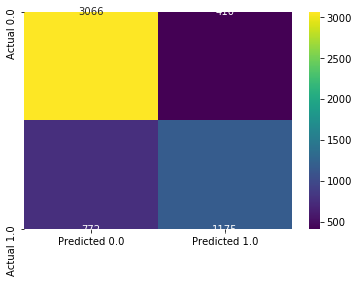

In [77]:
#confusion matrix
y_pred = model.predict(X_test)

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);
#misaligned data but okay

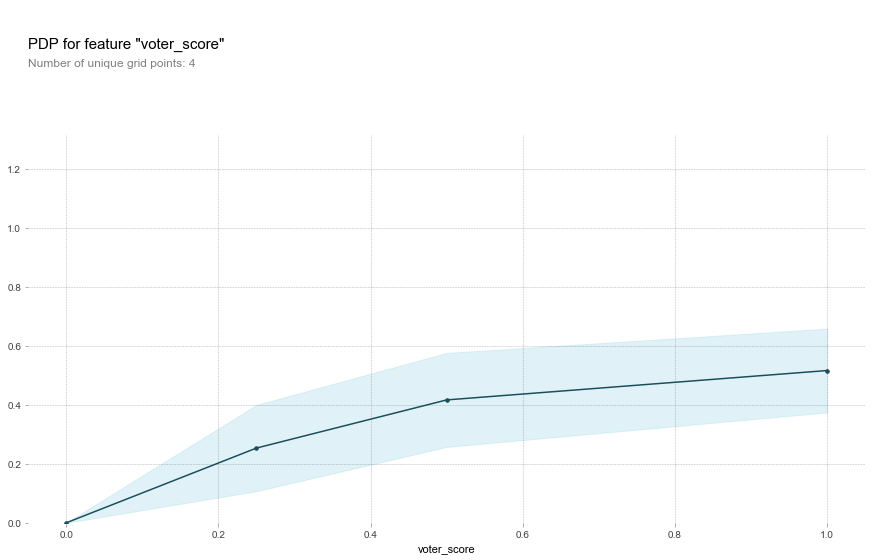

In [80]:
#pdp, one feature isolation
feature = 'voter_score'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

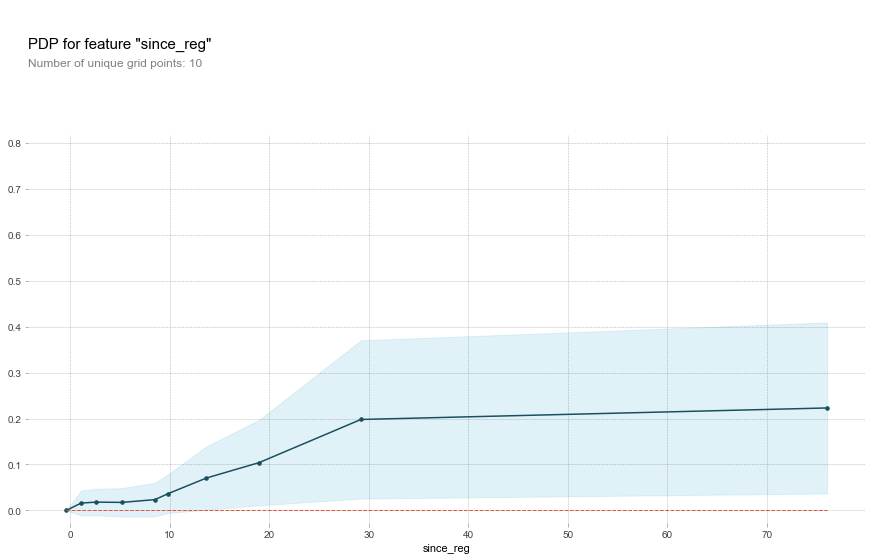

In [82]:
feature = 'since_reg'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

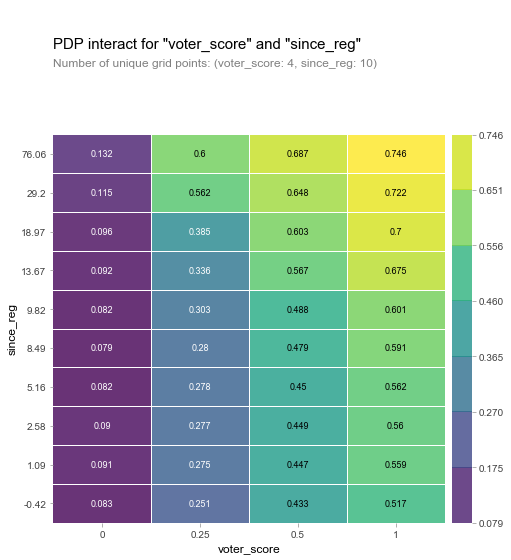

In [84]:
#pdp, two feature interaction
features = ['voter_score', 'since_reg']

interaction = pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
#now THAT is a lovely interaction!!!

In [89]:
#shapley values
row = X_test.iloc[[4]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

print(y_test.iloc[4])
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)
#barely a false negative

1.0
